In [4]:
# !pip install SpeechRecognition
# !pip install Levenshtein fuzzywuzzy
# !pip install -U openai-whisper
# !pip install pyttsx3
# !pip install word2number

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for word2number: filename=word2number-1.1-py3-none-any.whl size=5602 sha256=519ea4061b7eb7f4b78b20e8c976cb2aaa1aa01bf4f72fba8f96a599ec0a4ae2
  Stored in directory: c:\users\victo\appdata\local\packages\pythonsoftwarefoundation.python.3.9_qbz5n2kfra8p0\localcache\local\pip\cache\wheels\a0\4a\5b\d2f2df5c344ddbecb8bea759872c207ea91d93f57fb54e816e
Successfully built word2number


You should consider upgrading via the 'C:\Users\victo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [3]:
import whisper
import pyttsx3
import speech_recognition as sr
from fuzzywuzzy import process
import re
import pandas as pd
from word2number import w2n
from planner import do_planning
from IPython.display import Image

#######################
# CARREGUEM MODEL ASR #
#######################

model = whisper.load_model("small")
listener = sr.Recognizer()
engine = pyttsx3.init() 
voices = engine.getProperty('voices')
engine.setProperty("voice", voices[1].id)

######################
# PARAULES CORRECTES #
######################
df = pd.read_csv("products.csv", delimiter=";")

def tiene_numero(cadena):
    for caracter in cadena:
        if caracter.isdigit():
            return True
    return False

def ultimo_caracter_especial(cadena):
    caracteres_especiales = "!@#$%^&*()_+-=[]{}|;:,.<>?/~"
    ultimo_caracter = cadena[-1]
    if ultimo_caracter in caracteres_especiales:
        return True
    else:
        return False

list_correct_words = set()

# Paraules correctes pel corrector
for i in df["name"]:
    str_split = i.split(" ")
    for element in str_split:
        if len(element) >= 3 and not tiene_numero(element):
            if element[-1] == "-":
                list_correct_words.add(element[0:len(element)-1])
            else:
                list_correct_words.add(element)
# print(len(list_correct_words))
# print(list_correct_words)

############      
# FUNCIONS #
############ 

#Funció per asistent que parli
def talk(text):
    engine.say(text)
    engine.runAndWait()

#Funció per a que l'assistent escolti:
def run_mike():
    talk("I listen to you")
    with sr.Microphone() as source:
        audio = listener.listen(source)

        with open("audio_prueba" + ".wav", "wb") as f:
            f.write(audio.get_wav_data())

    talk("Record end")
    frase = to_text()
    return frase

#Funció per passar el audio a text amb whiper-ai
def to_text():
    result = model.transcribe("audio_prueba.wav", language = "en")
    print(result["text"])
    return result["text"]
def to_numbers(cadena):
    # initializing string
    new_cadena =""
    for word in cadena.split(" "):
        try:
            res = w2n.word_to_num(word)
            new_cadena += " "+str(res)
        except:
            new_cadena += " "+word
    print(new_cadena)
    return new_cadena
#Funció per 
def prueba(cadena):
    # Definir la expresión regular para encontrar todas las cantidades y productos
    regex = r"(\d+) \w+ of ([\w\s]+)(?:[and,.]|$)"

    # Frase con varias cantidades y productos
    frase = to_numbers(cadena)
    #frase = "Quiero 3 unidades de glucantime, 1 unidad de ScaliboardPek y 2 unidades de contenedor para muestras."

    #frase = cadena

    # Buscar todas las coincidencias
    coincidencias = re.findall(regex, frase)
    print(coincidencias)
    # Crear un diccionario a partir de las coincidencias
    diccionario = {}
    for cantidad, producto in coincidencias:
        producto = producto.strip()  # Eliminar espacios en blanco al inicio o al final
        diccionario[producto] = int(cantidad)

    print(diccionario)
    return diccionario
def return_best_match(element, correct_words):
    # Finding the best match with the default scorer (Levenshtein)
    best_match, similarity = process.extractOne(element, correct_words)

    print(f"Best match for '{element}': {best_match} (Similarity: {similarity}%)")
    return best_match, similarity

def print_list(dict):
    for key,value in dict.items():
        val = df[df["id"] == key]["name"].values[0]
        print(f"-> {val} : {value}")
  
def clean(dict_raw):
    dict_clean = {}
    for key,value in dict_raw.items():
        # Finding the best match with the default scorer (Levenshtein)
        best_matches = []
        matches_num = [] # Probably more specific
        for element in key.split(" "):
            if len(element) >= 3 and not tiene_numero(element):
                best_matches.append(return_best_match(element, list_correct_words)[0])
            else:
                matches_num.append(element)
        dict_puntuation = {product: 0 for product in df["name"]}
        for match in best_matches:
            for product in df["name"]:
                if match in product:
                    dict_puntuation[product] += 1
        productos_posibles = []
        max_valor = max(dict_puntuation.values())
        # Usar una comprensión de diccionario para obtener las llaves con el valor máximo
        productos_posibles = [llave for llave, valor in dict_puntuation.items() if valor == max_valor]
        for prod in productos_posibles:
            print(f"El producto podria ser (al menos una coincidencia con la transcripción): {prod}")
        if len(productos_posibles) == 0:
            print("No se ha encontrado ninguna coincidencia.")
        elif len(productos_posibles) == 1:
            id_quant = df[df["name"] == productos_posibles[0]]["id"].values[0]
            dict_clean[id_quant] = int(value)
            print(f"Gracias, acabas de pedir el producto {productos_posibles[0]} con la cantidad de {value}")

        else:
            correct_specs = set()
            # Especificamos con los números otra vez con el corrector
            for element in productos_posibles:
                if not (len(element) >= 3 and not tiene_numero(element)):
                    correct_specs.add(element)  
            matches_spec = []
            for element in matches_num:
                matches_spec.append(return_best_match(element, correct_specs)[0])
            dict_puntuation_specs = {spec: 0 for spec in correct_specs}
            for match in matches_spec:
                for product in correct_specs:
                    if match in product:
                        dict_puntuation_specs[product] += 1

            # Encontrar el valor máximo en el diccionario
            max_valor = max(dict_puntuation_specs.values())

            # Usar una comprensión de diccionario para obtener las llaves con el valor máximo
            productos_posibles = [llave for llave, valor in dict_puntuation_specs.items() if valor == max_valor]

            if len(productos_posibles) == 0:
                print("No se ha encontrado ninguna coincidencia.")

            elif len(productos_posibles) == 1:
                id_quant = df[df["name"] == productos_posibles[0]]["id"].values[0]
                dict_clean[id_quant] = int(value) 
                print(f"Producto escogido: {productos_posibles}")
            else:
                talk("Que producto quieres?")
                numeros = ["one", "two", "three", "four", "five"]
                for i in range(len(productos_posibles)):
                    talk(f"If you want {productos_posibles[i]} say {numeros[i]}")
                res = run_mike()
                print(res)
                res = "one"
                indice = numeros.index(res)
                id_quant = df[df["name"] == productos_posibles[indice]]["id"].values[0]
                dict_clean[id_quant] = int(value)     

    print(dict_clean)
    return dict_clean
# If you don't have Levenshtein or fuzzywuzzy installed, you can install them via pip:

def main():
    frase = run_mike()
    #frase= "three units of glucantime one unit of ScaliboardPek and two units of contenedor para muestras."
    dict_raw = prueba(frase)
    dict_clean = clean(dict_raw)
    dict_clean = {56: 3, 210: 1, 243: 2}
    print_list(dict_clean)
    dict_string = {}
    for key, value in dict_clean.items():
        dict_string[str(key)] = value
    talk("Is the list correct or do you want to modify it?")
    do_planning(dict_string)

main()

-> CONOFITE 20ml : 3
-> SCALIBOR PEQ 48cm : 1
-> CONTENEDOR PARA- MUESTRAS 150ml : 2
{'56': 3, '210': 1, '243': 2}
Start  at location (0, 0) and pick 3 units of CONOFITE 20ml
Move to location (1, 0)
Move to location (2, 0)
Move at location (3, 0)
and pick 2 products:
1 units of SCALIBOR PEQ 48cm, 2 units of CONTENEDOR PARA- MUESTRAS 150ml
Move to location (2, 0)
Move to location (1, 0)
Move to location (0, 0) to finish


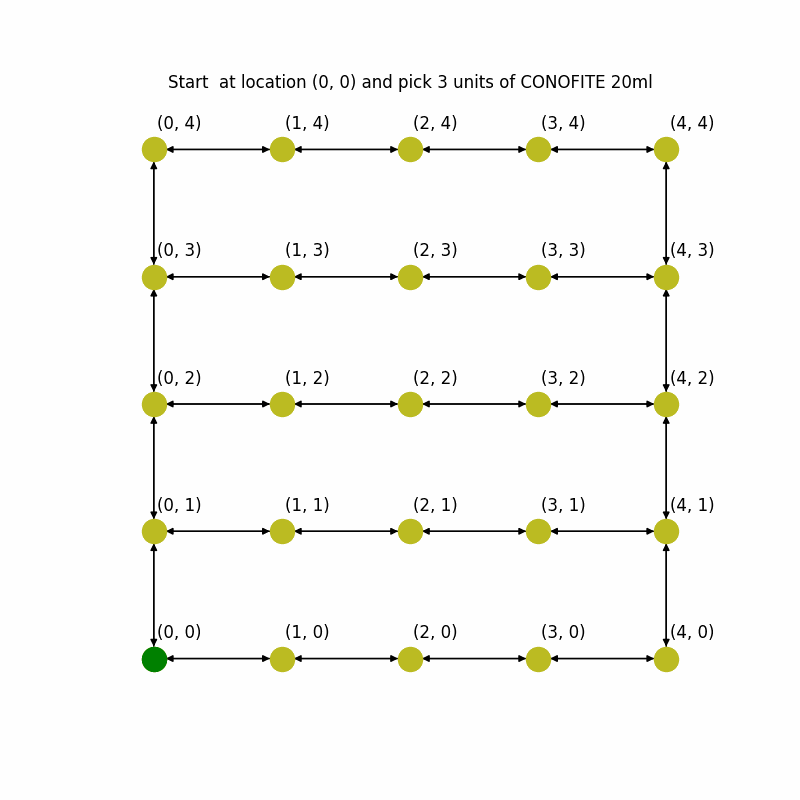

In [4]:
local_gif_path = "camino_optimo.gif"
Image(filename=local_gif_path)